In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.examples.tutorials.mnist import input_data 

In [11]:
import scipy as sc

In [4]:
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)

Extracting ../MNIST_data\train-images-idx3-ubyte.gz
Extracting ../MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data\t10k-labels-idx1-ubyte.gz


In [7]:
val = {}
ndata = 500
val['image'] = mnist.validation.images[:ndata]
val['label'] = mnist.validation.labels[:ndata]

In [87]:
sq_dist= np.zeros([ndata, ndata])
for i in range(ndata):
    for j in range(ndata):
        sq_dist[i][j] = np.sum(np.square(val['image'][i]-val['image'][j]))

In [90]:
def normalize(array):
    
    return array/np.sum(array)

In [100]:
def get_entropy(array):

    if np.sum(array) !=1:
        array = normalize(array)
        
    sum_ = 0
    length = len(array)
    for i in range(length):
        if array[i]!=0:
            sum_+=array[i]*np.log2(array[i])
    return -sum_

In [101]:
def get_prob(sigma_ld):
    
    prob = np.zeros([ndata, ndata])
    for i in range(ndata):
        for j in range(ndata):
            prob[i][j] = np.exp(-sq_list[i][j]/2/sigma_ld[i]/sigma_ld[i])
    
    for i in range(ndata):
        prob[i][i] = 0
    
    for i in range(ndata):
        prob[i] = normalize(prob[i])
    
    return prob

In [102]:
def get_prob_1d(row, sigma):
    
    prob = np.zeros(ndata)
    for j in range(ndata):
        prob[j] = np.exp(-sq_dist[row][j]/2/sigma/sigma)

    prob[row] = 0 
    
    return normalize(prob)

In [103]:
def get_perp(entropy):
    return np.power(2, entropy)

In [104]:
def get_shape(tensor):
    
    return tensor.get_shape().as_list()

In [130]:
def clip(x, vmax = 1-1e-10, vmin = 1e-10):
    return tf.clip_by_value(x, clip_value_max=vmax, clip_value_min=vmin)

In [138]:
def t_sne(y):
    
    batch, nmap = get_shape(y)
    y_tr = tf.transpose(y)
    y_mapped = []
    for i in range(nmap):
        y_mapped.append(tf.transpose([y_tr[i]])-y_tr[i])
    y_square = 0
    for i in range(nmap):
        y_square+= tf.square(y_mapped[i])
    y_add = y_square+1
    y_div = tf.div(1., y_add)
    y_mask = y_div*(1-tf.eye(batch))
    y_sum = tf.reduce_sum(y_mask)
    y_normalize = y_mask/y_sum
    cost = -tf.reduce_mean(joint_prob*tf.log(clip(y_normalize)))
    return cost, y_tr, y_mapped


In [107]:
max_try = 2000
boundary = 1
perp = 20
sigma = np.ones(ndata)

In [108]:
#利用困惑度求解合适的sigma
for i in range(ndata):
    smax = np.max(sq_dist)
    smin = np.min(sq_dist)
    cur_perp = get_perp(get_entropy(get_prob_1d(i, sigma[i])))
    trial = 0
    perp_diff = np.abs(perp - cur_perp)
    while perp_diff > boundary and trial < max_try:
        trial+=1
        if perp>cur_perp:
            smin = sigma[i]
            sigma[i] = (sigma[i]+smax)/2
        else: 
            smax = sigma[i]
            sigma[i] = (sigma[i]+smin)/2
        cur_perp = get_perp(get_entropy(get_prob_1d(i, sigma[i])))
        perp_diff = np.abs(perp - cur_perp)

In [110]:
prob = get_prob(sigma)

In [111]:
joint_prob = np.zeros((ndata, ndata))
for i in range(ndata):
    for j in range(nadata):
        joint_prob[i][j] = (prob[i][j] + prob[j][i])/2/ndata

In [115]:
image_size = 784
hidden1 = 500
hidden2 = 500
hidden3 = 2000

In [236]:
x = tf.placeholder(dtype=tf.float32, shape=[1000, image_size], name='image')
layer1 = {}
layer2 = {}
layer3 = {}
layer4 = {}
with tf.variable_scope('layer1'):
    layer1['w'] = tf.Variable(initial_value = tf.random_normal(shape = [image_size, hidden1], mean = 0.0, stddev = 1.0),
                                  name = 'weight')
    layer1['b'] = tf.Variable(1.0, name='bias1')
    layer1['output'] = tf.nn.relu(tf.add(tf.matmul(x, layer1['w']) , layer1['b']))

In [237]:
with tf.variable_scope("layer2"):
    layer2['w'] = tf.Variable(initial_value = tf.random_normal(shape = [hidden1, hidden2], mean = 0.0, stddev = 1.0),
                                  name = 'weight')
    layer2['b'] = tf.Variable(initial_value = 1.0,
                                  name = 'bias')
    layer2['output'] = tf.nn.relu(tf.add(tf.matmul(layer1['output'], layer2['w']), layer2['b']))

with tf.variable_scope("layer3"):
    layer3['w'] = tf.Variable(initial_value = tf.random_normal(shape = [hidden2, hidden3], mean = 0.0, stddev = 1.0),
                                  name = 'weight')
    layer3['b'] = tf.Variable(initial_value = 1.,
                                  name = 'bias')
    layer3['output'] = tf.nn.relu(tf.add(tf.matmul(layer2['output'], layer3['w']), layer3['b']))

with tf.variable_scope("layer4"):
    layer4['w'] = tf.Variable(initial_value = tf.random_normal(shape = [hidden3, 3], mean = 0.0, stddev = 1.0),
                                  name = 'weight')
    layer4['b'] = tf.Variable(initial_value = 1.0,
                                  name = 'bias')
    layer4['output'] = tf.add(tf.matmul(layer3['output'], layer4['w']), layer4['b'])

In [228]:
cost, y_tr, y_mapped = t_sne(layer4['output'])


In [229]:
learning_rate = tf.Variable(1e-2, trainable=False)
run_train = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [230]:
train_steps = 10000
log_every = 2000
sess= tf.Session()
sess.run(tf.global_variables_initializer())
lr_decay = tf.assign(learning_rate, sess.run(learning_rate))

In [231]:
cost_tract = []
for step in range(train_steps):
    _, c = sess.run([run_train, cost], feed_dict={x : val['image']})
    cost_tract.append(c)
    if step%log_every == log_every - 1:
        print("{} step cost : {}".format(step+1, c))

2000 step cost : 3.966054646298289e-05
4000 step cost : 3.954894418711774e-05
6000 step cost : 3.952990664402023e-05
8000 step cost : 3.952809129259549e-05
10000 step cost : 3.952693077735603e-05


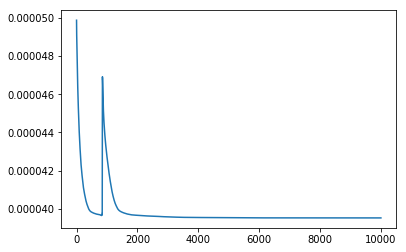

In [232]:
plt.plot(cost_tract)
plt.show()

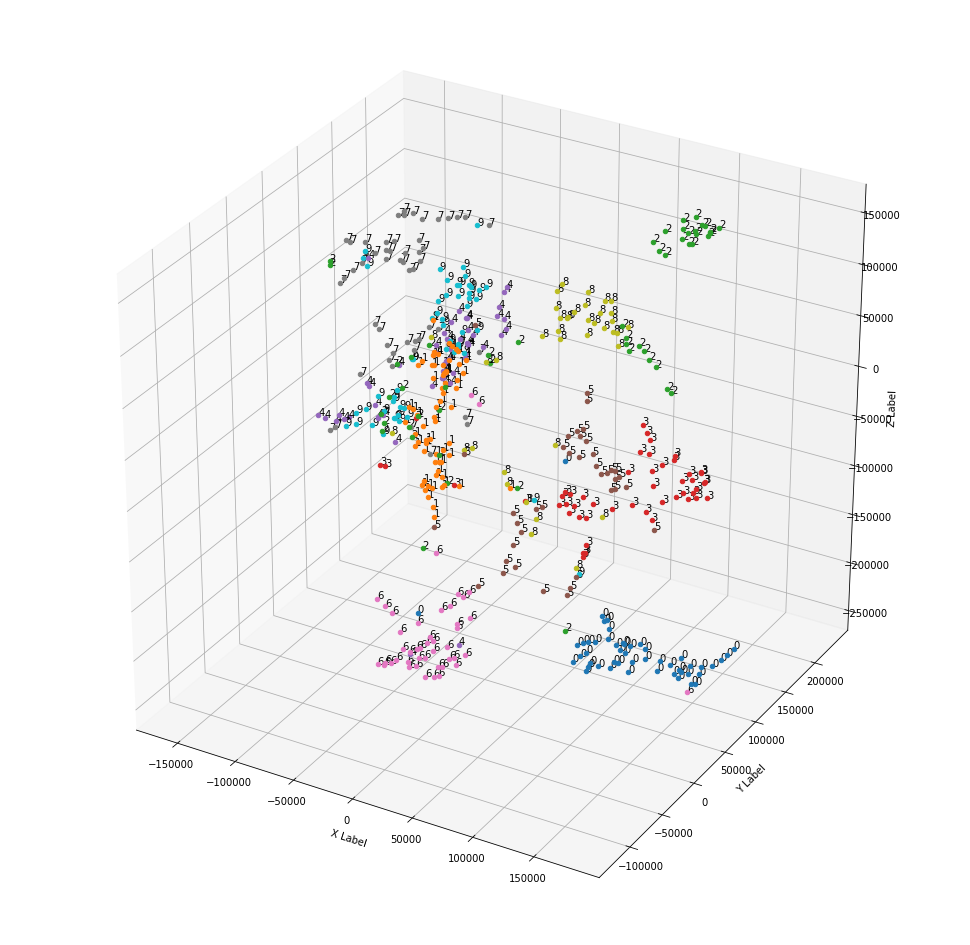

In [233]:
mapped = sess.run(layer4['output'], feed_dict = {x : val['image']})
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
fig = plt.figure(figsize=(17,17))
ax = fig.gca(projection='3d')

for i in range(ndata):
    ax.scatter(mapped[i][0], mapped[i][1], mapped[i][2], c= color[np.argmax(val['label'][i])])
    ax.text(mapped[i][0], mapped[i][1], mapped[i][2],str(np.argmax(val['label'][i])))
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()